# IDEB -  Clusterização e previsão de fatores mais influentes

## Variáveis
##### Todos os valores são referentes ao ensino médio da rede pública estadual

**id_municipio**: Identificador de sete dígitos do IBGE<br>
**uf**: Sigla da unidade da federação do estado<br>
**nome_município**: Nome do município conforme nomenclatura do IBGE<br>
**ideb_2017**: Valor observado do IDEB para o município<br>
**aluno_turma**: Número de alunos por turma (média)<br>
**hora_aula**: Número de aulas por dia (média)<br>
**prof_cs**: Professores com formação superior (percentual)<br>
**aprovacao**: Taxa de aprovação (média percentual)<br>
**reprovacao**: Taxa de reprovação (média percentual)<br>
**abandono**: Taxa de abandono escolar, caracterizado pelo abandono e retorno à IE (média percentual)<br>
**distorcao**: Distorção idade-série (média percentual)<br>
**promocao**: Taxa de promoção para o ano seguinte, continuada ou não (média percentual)<br>
**repetencia**: Taxa de repetência (média percentual)<br>
**evasao**: Taxa de abandono escolar, caracterizado pela evasão e não retorno à IE (média percentual)<br>
**migracao_eja**: Taxa de migração para a EJA (média percentual)<br>

O IDEB (Índice de Desenvolvimento da Educação Básica) é a principal medida utilizada pelo Ministério da Educação (MEC) e pelas secretarias estaduais e municipais de educação para avaliar o desempenho e a qualidade global da educação e do ensino básico no Brasil. Ele é obtido como produto da taxa de aprovação unitária pelo desempenho escolar, por sua vez resultado da Prova Brasil/SAEB. 
Foram duas a principais perguntas que orientaram o presente trabalho: 1) há uma correlação direta entre as estatísticas educacionais consideradas e o valor do IDEB?; 2) é possível clusterizar os valores do IDEB considerando as mesmas estatísticas educacionais?

#### Clusterização
##### Distribuição geográfica

#### Fatores preditivos



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
from PIL import Image

import geopandas as gpd
from geopandas import GeoSeries
from shapely.geometry import Point

from sklearn.cluster import KMeans, MiniBatchKMeans

%matplotlib inline

In [3]:
pd.options.display.max_rows = 100

In [4]:
#Carregamento e processamento dos dados do IDEB por cidade
df = pd.read_excel('divulgacao_ensino_medio_municipios_2019.xlsx')
df = df.drop(df.index[:8])
df = df.drop(df.index[11634:])
df = df.rename(columns=df.iloc[0])
df = df.drop(df.index[0])
df = df[df.REDE == 'Estadual']
df = df.drop(df.columns[5:22], axis=1)
df = df.drop(['VL_APROVACAO_2017_SI_4', 'VL_OBSERVADO_2019', 'VL_PROJECAO_2019', 'VL_PROJECAO_2021'], axis=1)
df.columns = ('uf', 'id_municipio', 'nome_municipio', 'rede', 'ideb_2017')

In [5]:
#Remoção das cidades sem valor do IDEB
df_sem_vf = df[df.ideb_2017 != '-']

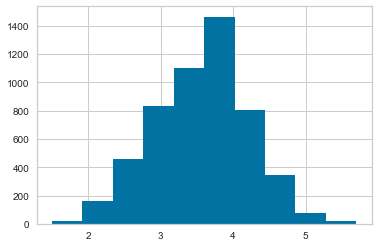

In [6]:
fig = plt.hist(x=df_sem_vf.ideb_2017)

In [7]:
#Alunos por turma (média)
aturma = pd.read_excel('ATU_MUNICIPIOS_2017.xlsx')
aturma = aturma.rename(columns=aturma.iloc[0]) 
aturma = aturma.iloc[1:] 
aturma.columns=['uf', 'id_municipio', 'nome_municipio', 'local', 'rede', 'aluno_turma']
aturma = aturma.iloc[:-3]
aturma = aturma[aturma.local == 'Total']
aturma = aturma[aturma.rede == 'Estadual']
df_final = pd.merge(df_sem_vf,aturma,on='id_municipio')

In [8]:
#Horas de aula por dia(média)
hora_aula = pd.read_excel('HAD_MUNICIPIOS_2017.xlsX')
hora_aula.columns=['uf', 'id_municipio', 'nome_municipio', 'local', 'rede', 'hora_aula']
hora_aula = hora_aula[hora_aula.local == 'Total']
hora_aula = hora_aula[hora_aula.rede == 'Estadual']
df_final = pd.merge(df_final,hora_aula,on='id_municipio')

In [9]:
#Professores com curso superior (percentual)
prof_cs = pd.read_excel('DSU_MUNICIPIOS_2017.xlsx')
prof_cs.columns=['uf', 'id_municipio', 'nome_municipio', 'local', 'rede', 'prof_cs']
prof_cs = prof_cs[prof_cs.local == 'Total']
prof_cs = prof_cs[prof_cs.rede == 'Estadual']
df_final = pd.merge(df_final,prof_cs,on='id_municipio')

In [10]:
df_final = df_final[['uf_x', 'local_x', 'rede_x', 'id_municipio', 
                     'nome_municipio_x', 'ideb_2017', 'aluno_turma', 'hora_aula', 'prof_cs']]
df_final = pd.read_excel('dados.xlsx')
df_final.columns = ['uf', 'local', 'rede', 'id_municipio', 'nome_municipio', 'ideb_2017', 
                    'aluno_turma', 'hora_aula', 'prof_cs']

In [11]:
#Taxas de rendimento - aprovação, reprovação e abandono escolar (percentual)
rendimento = pd.read_excel('TX_REND_MUNICIPIOS_2017.xlsx')
rendimento.columns = ['uf', 'id_municipio', 'nome_municipio','local', 'rede', 'aprovacao', 'reprovacao', 'abandono']
rendimento = rendimento[rendimento.local == 'Total']
rendimento = rendimento[rendimento.rede == 'Estadual']
    
del rendimento['uf']
del rendimento['nome_municipio']
del rendimento['local']
del rendimento['rede']

df_final = pd.merge(df_final,rendimento,on='id_municipio')

del df_final['local']
del df_final['rede']

In [12]:
#Distorção idade-série (percentual)
distorcao = pd.read_excel('TDI_MUNICIPIOS_2017.xlsx')
distorcao = distorcao[distorcao.local == 'Total']
distorcao = distorcao[distorcao.rede == 'Estadual']

del distorcao['local']
del distorcao['rede']

df_final = pd.merge(df_final,distorcao,on='id_municipio')

In [13]:
#Taxas de transição
transicao = pd.read_excel('TX_TRANSICAO_MUNICIPIOS_2017_2018.xlsx')
transicao = transicao.iloc[:-3]
transicao = transicao[transicao.local == 'Total']
transicao = transicao[transicao.rede == 'Pública']

del transicao['local']
del transicao['uf']
del transicao['nome_municipio']

df_final = pd.merge(df_final,transicao,on='id_municipio')

del df_final['rede']

In [14]:
#Exportação da tabela final
df_final.to_csv('dados_educacao_2017.csv')
df_final.to_excel('dados_educacao_2017.xlsx')

In [15]:
#Criação de vetor alvo (IDEB) e matriz com variáveis
X = df_final.drop(['ideb_2017', 'uf', 'nome_municipio', 'id_municipio'],   axis=1)
y = df_final['ideb_2017']

In [16]:
#Criação da tabela final com coordenadas dos município
coordenadas = pd.read_csv('coordenadas_municipios.csv')

del coordenadas['codigo_uf']
del coordenadas['capital']

coordenadas.columns = ['id_municipio', 'municipio', 'latitude', 'longitude']
df_final = pd.merge(df_final,coordenadas,on='id_municipio')

del df_final['municipio']

#Exportação da tabela final com coordenadas dos município
df_final.to_csv('df_final_coordenadas.csv')


del df_final['latitude']
del df_final['longitude']

In [17]:
df_final_kmeans = df_final.drop(['uf', 'nome_municipio', 'id_municipio'],   axis=1)

In [18]:
df_final_kmeans.head()


,ideb_2017,aluno_turma,hora_aula,prof_cs,aprovacao,reprovacao,abandono,distorcao,promocao,repetencia,evasao,migracao_eja
0,3.9,17.8,6.2,99.1,88.1,4.7,7.2,25.1,83.8,5.2,9.1,1.9
1,3.8,28.0,5.2,98.1,82.6,6.6,10.8,34.4,77.8,7.1,9.9,5.2
2,3.7,16.4,5.3,100.0,94.9,1.3,3.8,27.8,83.1,2.2,12.4,2.3
3,3.7,24.3,5.4,96.4,89.1,4.2,6.7,32.6,83.5,5.9,7.9,2.7
4,3.8,23.1,5.7,100.0,80.2,12.3,7.5,26.9,73.2,11.4,7.7,7.7


In [19]:
X

,aluno_turma,hora_aula,prof_cs,aprovacao,reprovacao,abandono,distorcao,promocao,repetencia,evasao,migracao_eja
0,17.8,6.2,99.1,88.1,4.7,7.2,25.1,83.8,5.2,9.1,1.9
1,28.0,5.2,98.1,82.6,6.6,10.8,34.4,77.8,7.1,9.9,5.2
2,16.4,5.3,100.0,94.9,1.3,3.8,27.8,83.1,2.2,12.4,2.3
3,24.3,5.4,96.4,89.1,4.2,6.7,32.6,83.5,5.9,7.9,2.7
4,23.1,5.7,100.0,80.2,12.3,7.5,26.9,73.2,11.4,7.7,7.7
...,...,...,...,...,...,...,...,...,...,...,...
5276,28.6,4.8,84.2,93.5,6,0.5,17.3,86.1,2.7,5.2,6
5277,22.6,5.2,100.0,97.8,2.2,0,18.2,82.5,6.2,9,2.3
5278,23.6,4.3,46.2,97.4,2.6,0,34.5,83.2,1.2,7.2,8.4
5279,24.0,4.3,45.0,98.7,1.3,0,27.4,92.7,0.6,5.5,1.2


### Dados não-escalonados (MinMax)

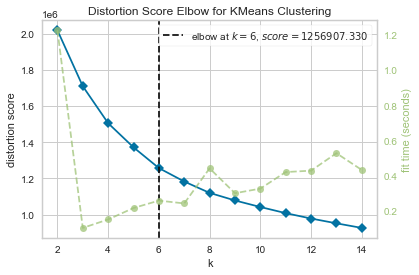

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15))

visualizer.fit(X)       
visualizer.show()    

C:\Users\Lucas\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Lucas\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Lucas\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


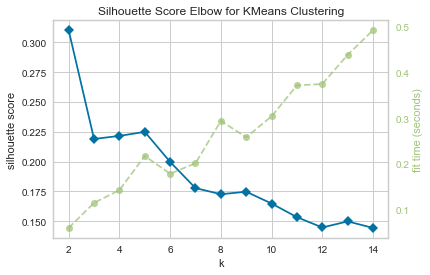

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='silhouette')

visualizer.fit(X) 
visualizer.show()       

In [22]:
#Escalonamento dos dados da matriz X
scaler = MinMaxScaler()
X_scal = scaler.fit_transform(X)

### Dados escalonados (MinMax)

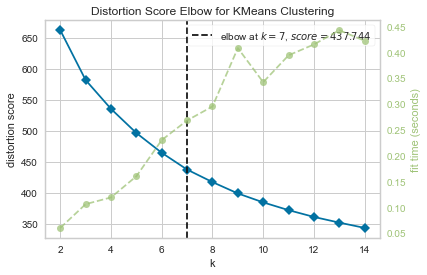

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='distortion')

visualizer.fit(X_scal)   
visualizer.show()      

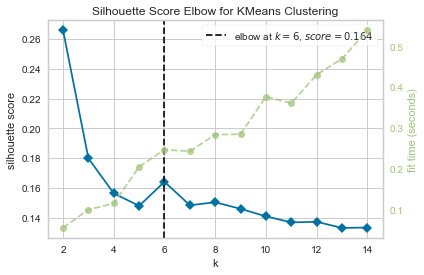

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [24]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='silhouette')

visualizer.fit(X_scal)   
visualizer.show()        

<AxesSubplot:xlabel='uf', ylabel='ideb_2017'>

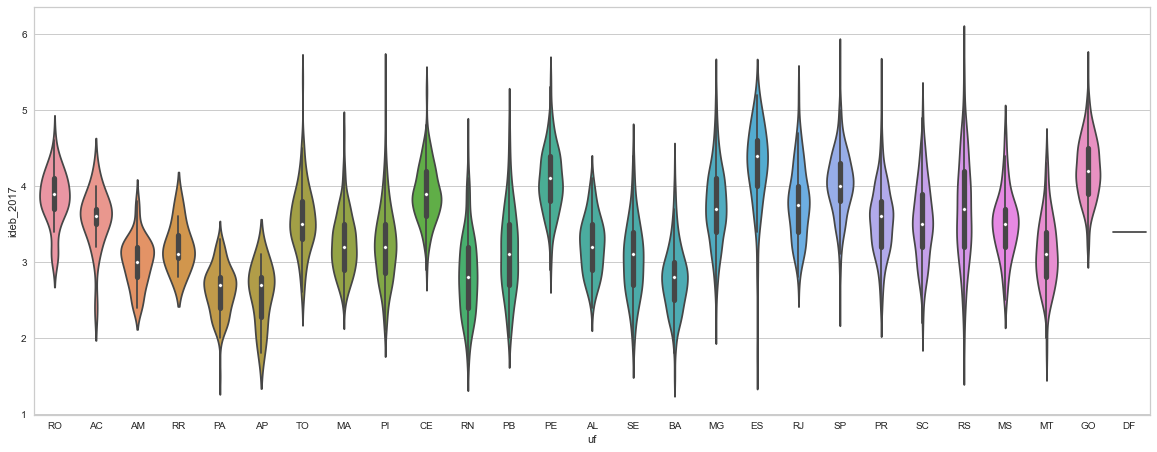

In [25]:
plt.subplots(figsize=(20,7.5))
sns.violinplot(x='uf', y='ideb_2017', data=df_final)

In [26]:
df_final_kmeans.head()

,ideb_2017,aluno_turma,hora_aula,prof_cs,aprovacao,reprovacao,abandono,distorcao,promocao,repetencia,evasao,migracao_eja
0,3.9,17.8,6.2,99.1,88.1,4.7,7.2,25.1,83.8,5.2,9.1,1.9
1,3.8,28.0,5.2,98.1,82.6,6.6,10.8,34.4,77.8,7.1,9.9,5.2
2,3.7,16.4,5.3,100.0,94.9,1.3,3.8,27.8,83.1,2.2,12.4,2.3
3,3.7,24.3,5.4,96.4,89.1,4.2,6.7,32.6,83.5,5.9,7.9,2.7
4,3.8,23.1,5.7,100.0,80.2,12.3,7.5,26.9,73.2,11.4,7.7,7.7


In [27]:
kmeans = KMeans(init='k-means++', n_clusters= 6, max_iter=1000, n_init=20).fit(df_final_kmeans)
centroides= kmeans.cluster_centers_
y_kmeans = kmeans.predict(df_final_kmeans)

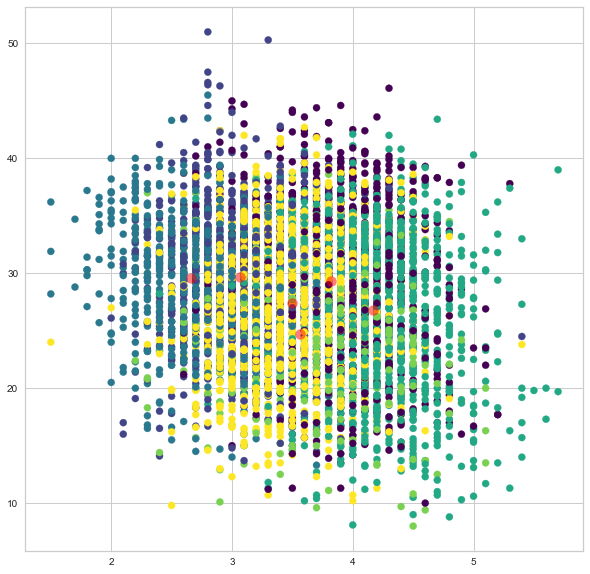

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);


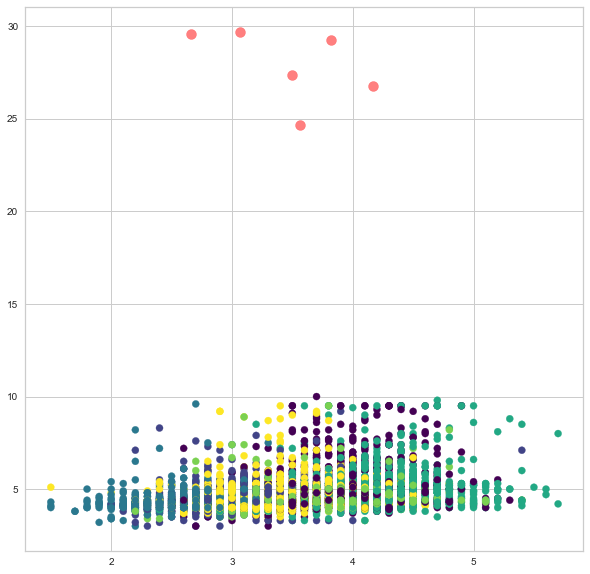

In [29]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 2], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);


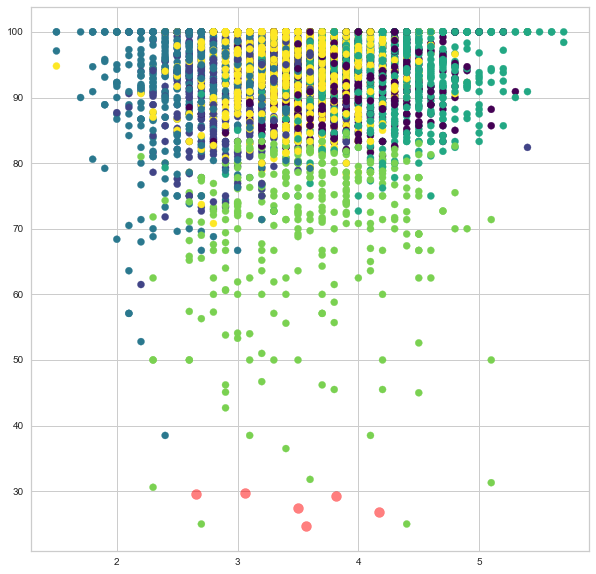

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 3], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

In [31]:
df_final_kmeans.iloc[:, 4]

0       88.1
1       82.6
2       94.9
3       89.1
4       80.2
        ... 
5276    93.5
5277    97.8
5278    97.4
5279    98.7
5280    78.3
Name: aprovacao, Length: 5281, dtype: object

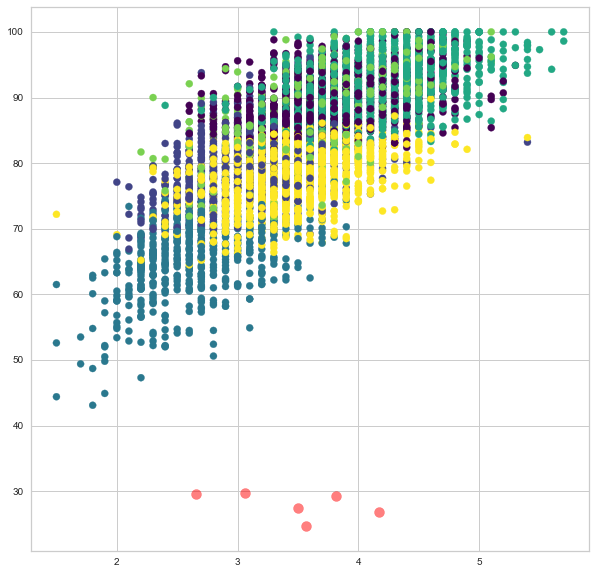

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 4], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

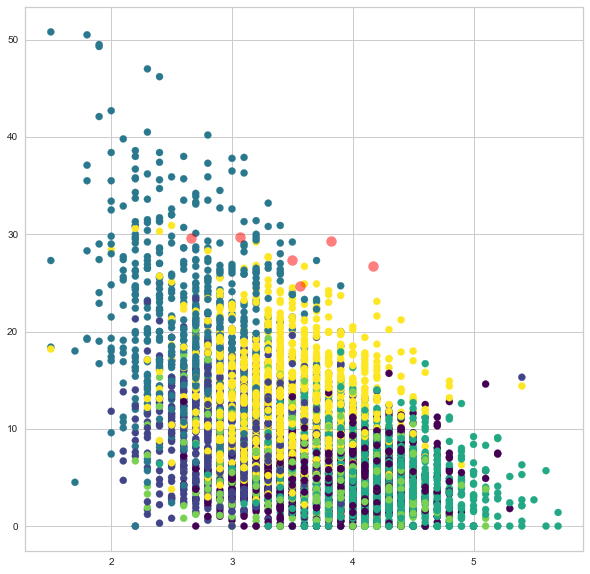

In [33]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 5], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

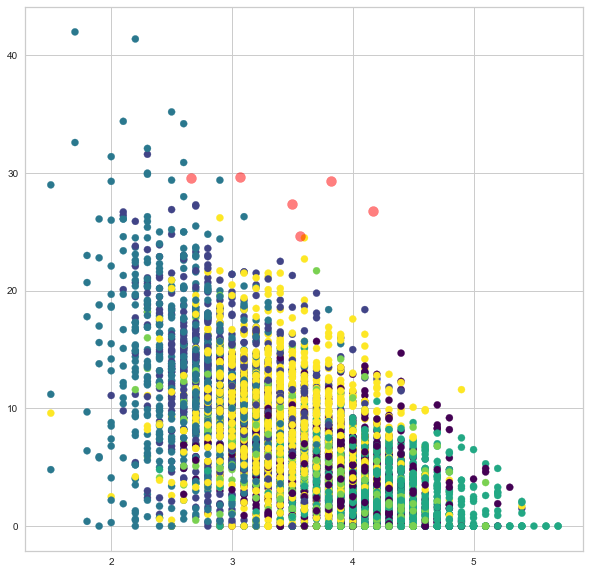

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 6], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

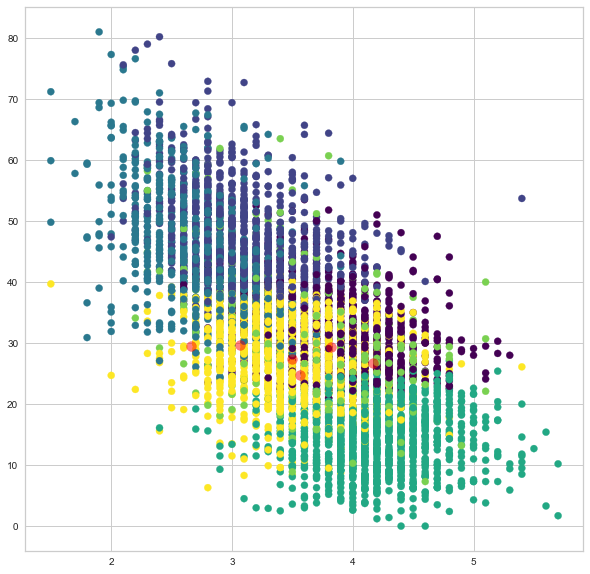

In [35]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 7], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

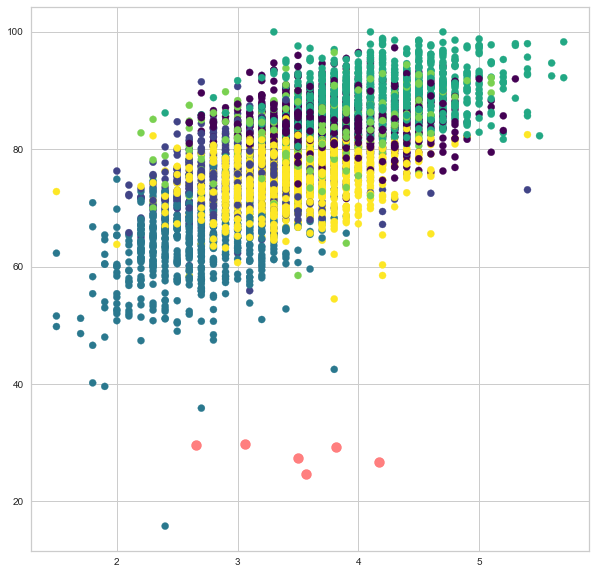

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 8], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

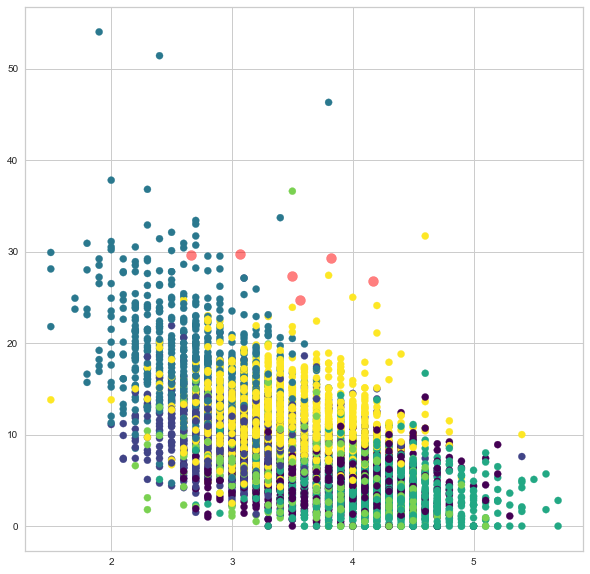

In [37]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 9], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

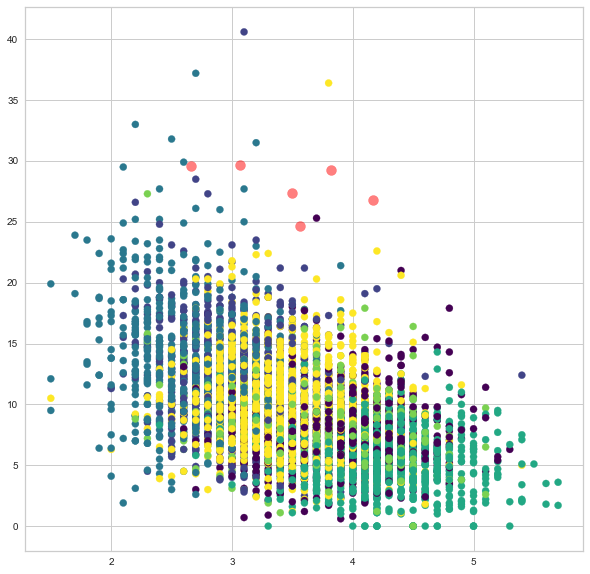

In [38]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 10], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

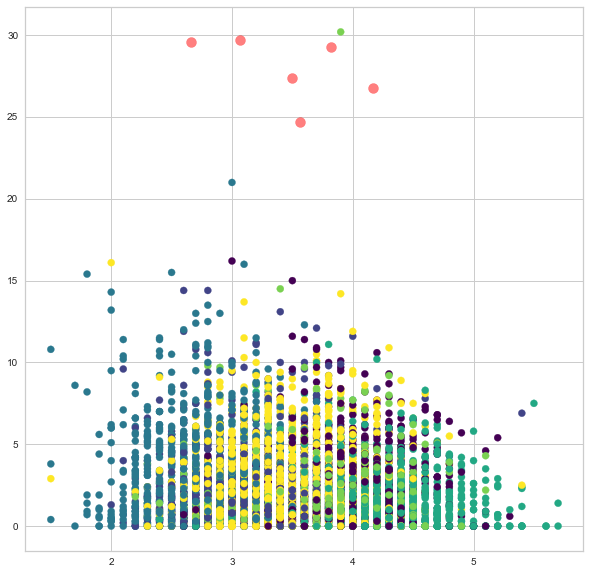

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(df_final_kmeans.iloc[:, 0], df_final_kmeans.iloc[:, 11], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=100, alpha=0.5);

In [40]:
df_final_coordenadas = pd.read_csv('df_final_coordenadas.csv')

In [48]:
X_std = StandardScaler().fit_transform(X)                                    

In [59]:
pca = PCA()
pca.fit(X_std)

PCA()

In [60]:
pca.explained_variance_ratio_

array([4.39446069e-01, 1.29045565e-01, 1.03806610e-01, 9.28946468e-02,
       7.14079642e-02, 6.38564702e-02, 4.61540381e-02, 4.13617043e-02,
       1.20269328e-02, 2.23619415e-32, 1.35116619e-32])

Text(0, 0.5, 'Variância cumulativa')

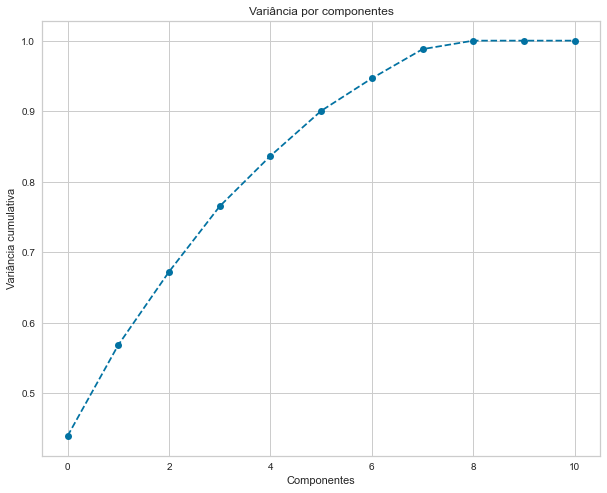

In [66]:
plt.figure(figsize = (10,8))
plt.plot(range(0,11), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Variância por componentes')
plt.xlabel('Componentes')
plt.ylabel('Variância cumulativa')

###### 4 componentes (~84%)

In [67]:
pca = PCA(n_components=4)

In [68]:
pca.fit(X_std)

PCA(n_components=4)

In [69]:
pca.transform(X_std)

array([[-1.48229902,  0.18093778, -0.23931029, -0.41647512],
       [ 0.25732421,  0.34267934,  0.61806436,  0.15245332],
       [-1.86370888, -0.57069932, -0.48703105, -0.43943481],
       ...,
       [-1.83505943, -0.84633824, -1.16862533,  6.17796021],
       [-3.21709397, -2.20134384, -1.22636169,  4.87319821],
       [ 1.19883542,  1.62880532,  0.55542086, -0.06149733]])

In [70]:
scores_pca = pca.transform(X_std)

In [71]:
scores_pca

array([[-1.48229902,  0.18093778, -0.23931029, -0.41647512],
       [ 0.25732421,  0.34267934,  0.61806436,  0.15245332],
       [-1.86370888, -0.57069932, -0.48703105, -0.43943481],
       ...,
       [-1.83505943, -0.84633824, -1.16862533,  6.17796021],
       [-3.21709397, -2.20134384, -1.22636169,  4.87319821],
       [ 1.19883542,  1.62880532,  0.55542086, -0.06149733]])

In [74]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 8)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

Text(0, 0.5, 'kmeans/pca')

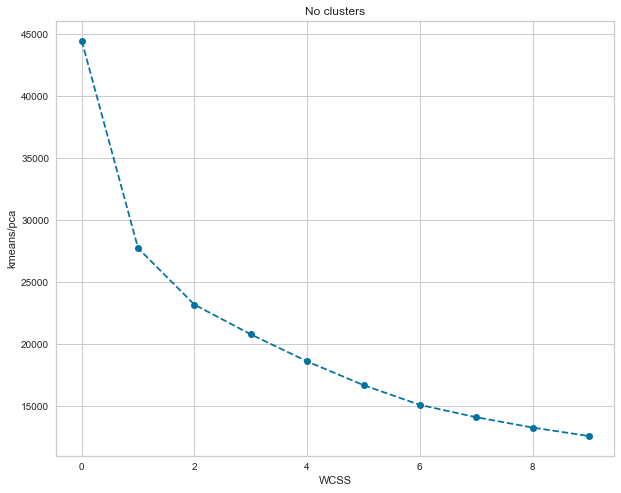

In [76]:
plt.figure(figsize = (10,8))
plt.plot(range(0,10), wcss, marker = 'o', linestyle = '--')
plt.title('No clusters')
plt.xlabel('WCSS')
plt.ylabel('kmeans/pca')

###### 3 clusters

In [79]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 8)

In [80]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=8)

In [83]:
df_pca_kmeans = pd.concat([df_final_kmeans.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_pca_kmeans.columns.values[-4:] = ['pca 1', 'pca 2', 'pca 3', 'pca 4']
df_pca_kmeans['k-means/pca'] = kmeans_pca.labels_

In [84]:
df_pca_kmeans.head()

,ideb_2017,aluno_turma,hora_aula,prof_cs,aprovacao,reprovacao,abandono,distorcao,promocao,repetencia,evasao,migracao_eja,pca 1,pca 2,pca 3,pca 4,k-means/pca
0,3.9,17.8,6.2,99.1,88.1,4.7,7.2,25.1,83.8,5.2,9.1,1.9,-1.482299,0.180938,-0.239310,-0.416475,1
1,3.8,28.0,5.2,98.1,82.6,6.6,10.8,34.4,77.8,7.1,9.9,5.2,0.257324,0.342679,0.618064,0.152453,2
2,3.7,16.4,5.3,100.0,94.9,1.3,3.8,27.8,83.1,2.2,12.4,2.3,-1.863709,-0.570699,-0.487031,-0.439435,1
3,3.7,24.3,5.4,96.4,89.1,4.2,6.7,32.6,83.5,5.9,7.9,2.7,-1.188840,0.021810,0.160945,-0.006213,1
4,3.8,23.1,5.7,100.0,80.2,12.3,7.5,26.9,73.2,11.4,7.7,7.7,0.684002,2.062460,-0.403257,0.375085,2


In [87]:
df_pca_kmeans['segmento'] = df_pca_kmeans['k-means/pca'].map({0 : 'cluster 1',
                                                              1 : 'cluster 2',
                                                            2 : 'cluster 3'})

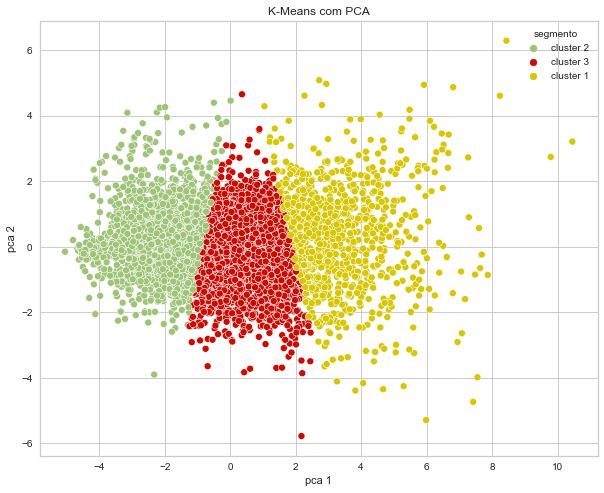

In [92]:
eixo_x = df_pca_kmeans['pca 1']
eixo_y = df_pca_kmeans['pca 2']
plt.figure(figsize = (10,8))
plt.title('K-Means com PCA')
sns.scatterplot(x = eixo_x, y = eixo_y, hue = df_pca_kmeans['segmento'], palette= ['g', 'r', 'y'])
plt.show()


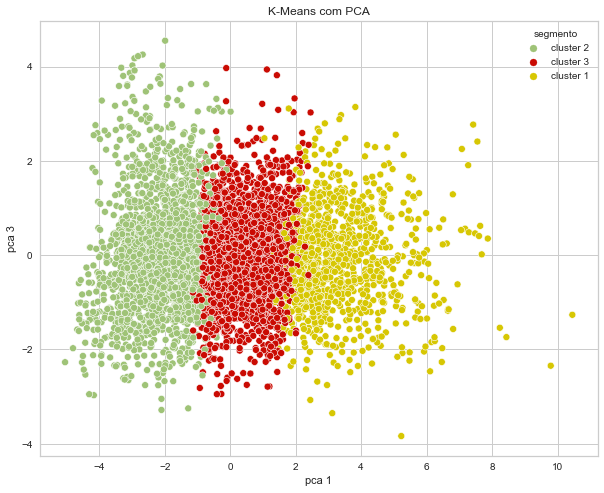

In [93]:
eixo_x = df_pca_kmeans['pca 1']
eixo_y = df_pca_kmeans['pca 3']
plt.figure(figsize = (10,8))
plt.title('K-Means com PCA')
sns.scatterplot(x = eixo_x, y = eixo_y, hue = df_pca_kmeans['segmento'], palette= ['g', 'r', 'y'])
plt.show()


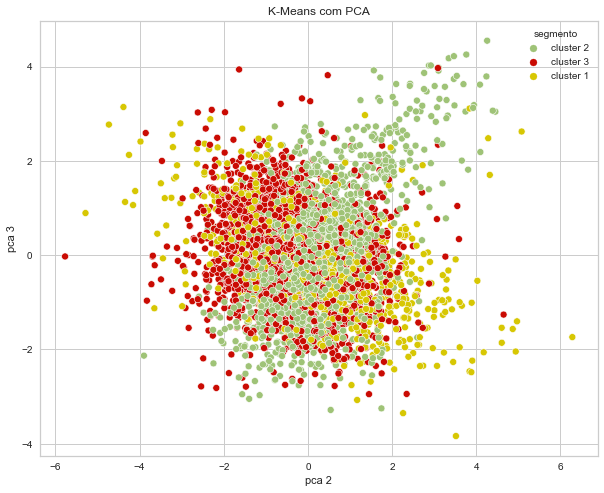

In [94]:
eixo_x = df_pca_kmeans['pca 2']
eixo_y = df_pca_kmeans['pca 3']
plt.figure(figsize = (10,8))
plt.title('K-Means com PCA')
sns.scatterplot(x = eixo_x, y = eixo_y, hue = df_pca_kmeans['segmento'], palette= ['g', 'r', 'y'])
plt.show()


In [96]:
agregado = df_pca_kmeans.groupby(["k-means/pca"]).mean()
agregado.style.background_gradient(cmap ='summer').set_properties(**{'font-size': '20px'}) 

,ideb_2017,aluno_turma,hora_aula,prof_cs,pca 1,pca 2,pca 3,pca 4
k-means/pca,,,,,,,,
0,2.847041,29.301775,4.421499,93.683629,3.308858,0.332386,-0.083190,0.036201
1,4.065692,27.493803,5.137134,93.412494,-2.148476,0.183950,0.041095,0.013778
2,3.411156,28.093333,4.511467,92.965867,0.434798,-0.314696,0.000651,-0.028666


In [98]:
df_final_kmeans.head()

,ideb_2017,aluno_turma,hora_aula,prof_cs,aprovacao,reprovacao,abandono,distorcao,promocao,repetencia,evasao,migracao_eja
0,3.9,17.8,6.2,99.1,88.1,4.7,7.2,25.1,83.8,5.2,9.1,1.9
1,3.8,28.0,5.2,98.1,82.6,6.6,10.8,34.4,77.8,7.1,9.9,5.2
2,3.7,16.4,5.3,100.0,94.9,1.3,3.8,27.8,83.1,2.2,12.4,2.3
3,3.7,24.3,5.4,96.4,89.1,4.2,6.7,32.6,83.5,5.9,7.9,2.7
4,3.8,23.1,5.7,100.0,80.2,12.3,7.5,26.9,73.2,11.4,7.7,7.7
